# Assignment2(5/18)

LightGBM / XGboost hyperparams tips
\
http://machinelearningkorea.com/2019/09/29/lightgbm-%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0/
\
About lightGBM : https://injo.tistory.com/48

## Import model

In [1]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np
import missingno as msno

import sklearn
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from lightgbm import LGBMRegressor


from scipy.stats import norm 
from sklearn.preprocessing import StandardScaler 
from scipy import stats 
import scipy as sp

import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import gc

In [3]:
print(xgb.__version__)
print(lgb.__version__)
print(msno.__version__)
print(sklearn.__version__)

1.7.5
3.3.5
0.5.2
1.2.2


## Data load

In [4]:
df_train = pd.read_csv('/content/drive/MyDrive/AIFFEL/Kaggle/housing/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/AIFFEL/Kaggle/housing/test.csv')

In [5]:
print(f'train data dim : {df_train.shape}')
print(f'test data dim : {df_test.shape}')

train data dim : (15035, 21)
test data dim : (6468, 20)


In [6]:
y = df_train['price']
id_test =df_test['id']

## EDA

In [7]:
#descriptive statistics summary
'''
min max 차이가 크고 std가 큰편이다
'''
y = df_train['price']
y.describe()

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

<Axes: xlabel='price', ylabel='Density'>

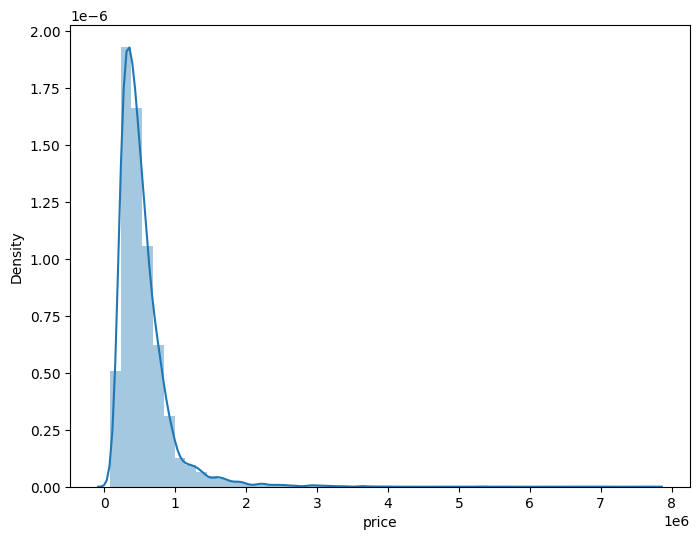

In [8]:
#histogram
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(y)

In [9]:
#skewness and kurtosis
print("Skewness: %f" % y.skew())
print("Kurtosis: %f" % y.kurt())

Skewness: 4.290252
Kurtosis: 40.154919


In [10]:
#Taking Log scaling
y = np.log1p(y)

<Axes: xlabel='price', ylabel='Density'>

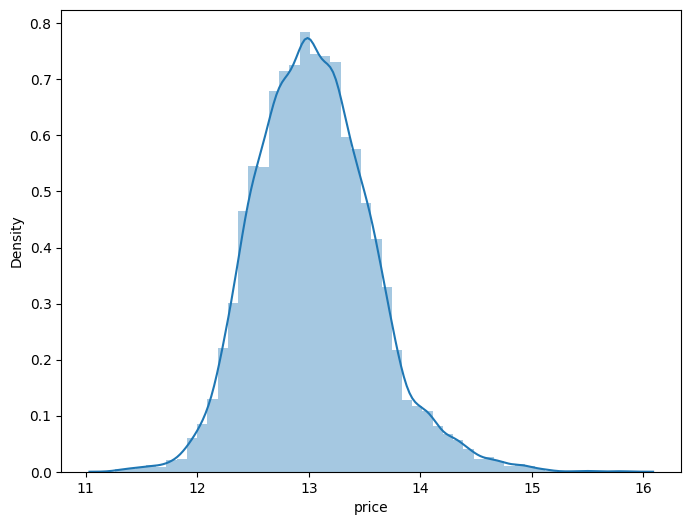

In [11]:
#histogram
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(y)

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


<Axes: >

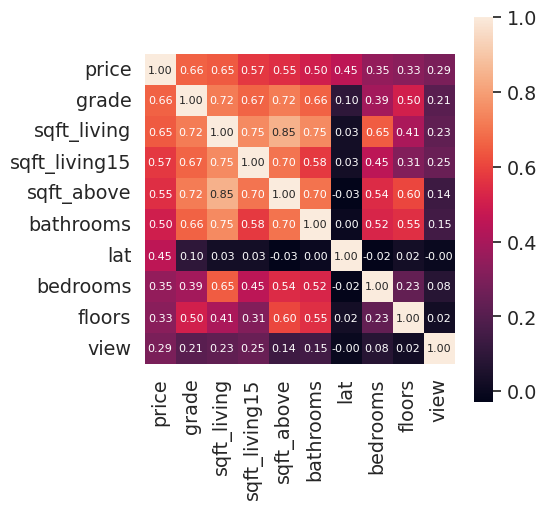

In [12]:
df_train['price'] = np.log1p(df_train['price'])
cor_abs = abs(df_train.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=10, columns='price').index # price과 correlation이 높은 column 10개 뽑기(내림차순)
# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(df_train[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(5,5))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

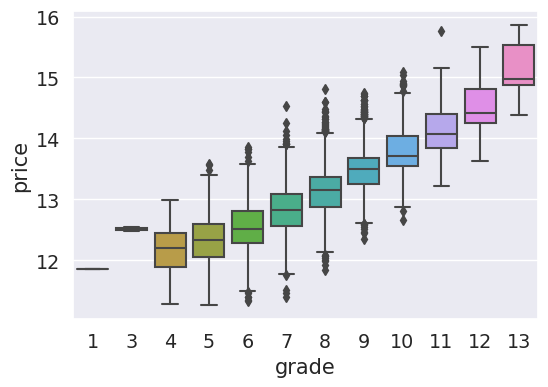

In [13]:
data = pd.concat([df_train['price'], df_train['grade']], axis=1)
f, ax = plt.subplots(figsize=(6, 4))
fig = sns.boxplot(x='grade', y="price", data=data)

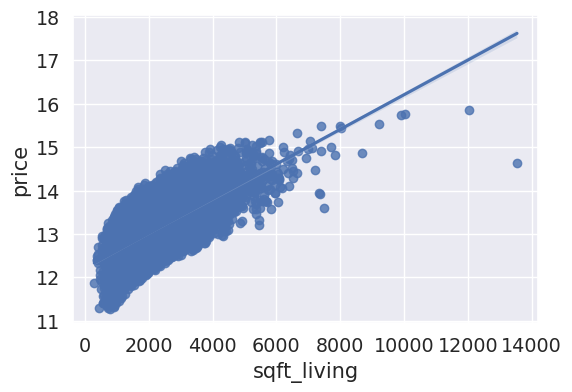

In [14]:
data = pd.concat([df_train['price'], df_train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(6, 4))
fig = sns.regplot(x='sqft_living', y="price", data=data)

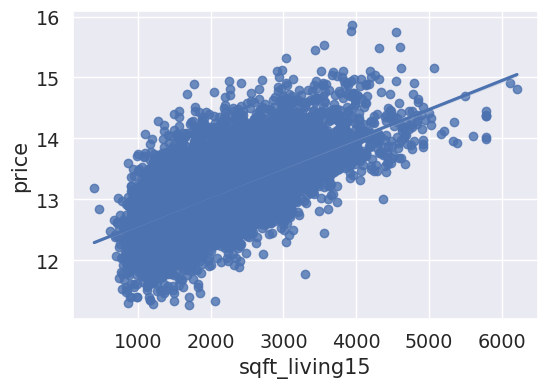

In [15]:
data = pd.concat([df_train['price'], df_train['sqft_living15']], axis=1)
f, ax = plt.subplots(figsize=(6, 4))
fig = sns.regplot(x='sqft_living15', y="price", data=data)

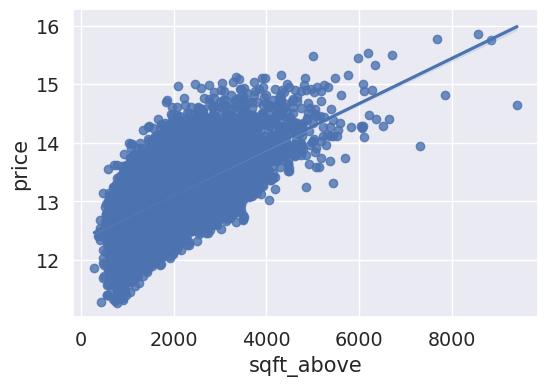

In [16]:
data = pd.concat([df_train['price'], df_train['sqft_above']], axis=1)
f, ax = plt.subplots(figsize=(6, 4))
fig = sns.regplot(x='sqft_above', y="price", data=data)

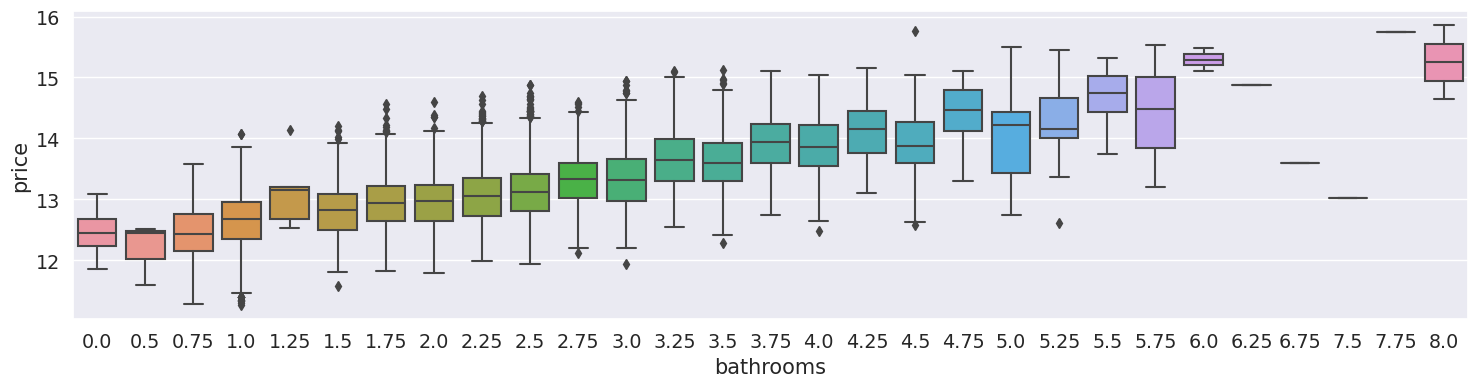

In [17]:
data = pd.concat([df_train['price'], df_train['bathrooms']], axis=1)
f, ax = plt.subplots(figsize=(18, 4))
fig = sns.boxplot(x='bathrooms', y="price", data=data)

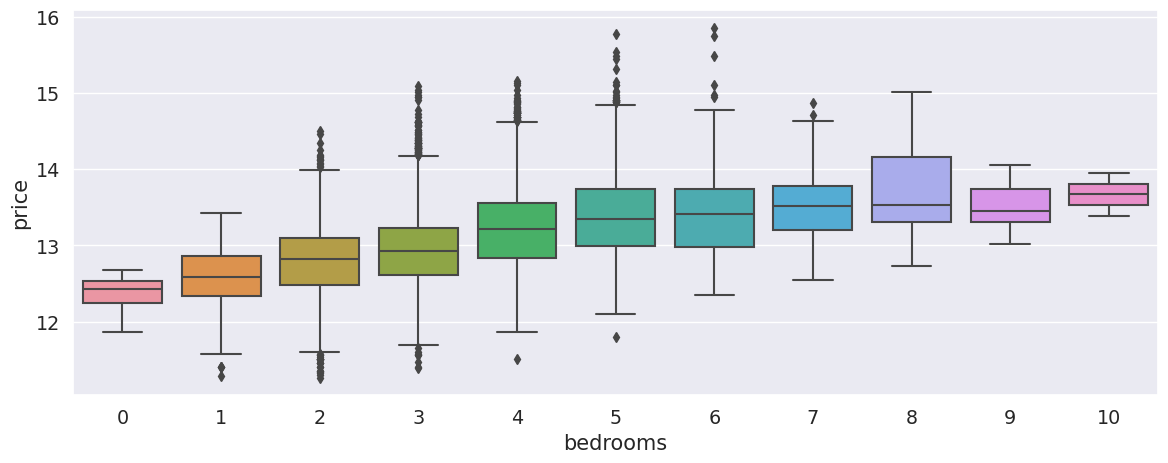

In [18]:
data = pd.concat([df_train['price'], df_train['bedrooms']], axis=1)
f, ax = plt.subplots(figsize=(14, 5))
fig = sns.boxplot(x='bedrooms', y="price", data=data)

In [19]:
df_train.loc[df_train['sqft_living'] > 13000]
df_train = df_train.loc[df_train['id']!=8990]

In [20]:
df_train.loc[(df_train['price']>12) & (df_train['grade'] == 3)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2302,2302,20150225T000000,12.476104,1,0.75,520,12981,1.0,0,0,...,3,520,0,1920,0,98022,47.2082,-121.995,1340,12233
4123,4123,20141104T000000,12.542548,1,0.00,600,24501,1.0,0,0,...,3,600,0,1950,0,98045,47.5316,-121.749,990,22549


In [21]:
df_train.loc[(df_train['price']>14.7) & (df_train['grade'] == 8)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7173,7173,20140813T000000,14.808763,5,4.0,4230,27295,2.0,1,4,...,8,3230,1000,1949,1985,98033,47.6803,-122.214,2660,27295


In [22]:
df_train.loc[(df_train['price']>15.5) & (df_train['grade'] == 11)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,20140611T000000,15.77031,5,4.5,10040,37325,2.0,1,2,...,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449


In [23]:
df_train = df_train.loc[df_train['id']!=456]
df_train = df_train.loc[df_train['id']!=2302]
df_train = df_train.loc[df_train['id']!=4123]
df_train = df_train.loc[df_train['id']!=7173]
df_train = df_train.loc[df_train['id']!=2775]

### Normalization

In [24]:
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    df_train[c] = np.log1p(df_train[c].values)
    df_test[c] = np.log1p(df_test[c].values)

In [25]:
for df in [df_train,df_test]:
    df['date'] = df['date'].apply(lambda x: x[0:8])
    df['yr_renovated'] = df['yr_renovated'].apply(lambda x: np.nan if x == 0 else x)
    df['yr_renovated'] = df['yr_renovated'].fillna(df['yr_built'])

In [26]:
df_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013,12.309987,3,1.00,7.074117,8.639588,1.0,0,0,...,7,7.074117,0.0,1955,1955.0,98178,47.5112,-122.257,1340,5650
1,1,20150225,12.100718,2,1.00,6.647688,9.210440,1.0,0,0,...,6,6.647688,0.0,1933,1933.0,98028,47.7379,-122.233,2720,8062
2,2,20150218,13.142168,3,2.00,7.427144,8.997271,1.0,0,0,...,8,7.427144,0.0,1987,1987.0,98074,47.6168,-122.045,1800,7503
3,3,20140627,12.458779,3,2.25,7.447751,8.827615,2.0,0,0,...,7,7.447751,0.0,1995,1995.0,98003,47.3097,-122.327,2238,6819
4,4,20150115,12.583999,3,1.50,6.966967,9.181118,1.0,0,0,...,7,6.966967,0.0,1963,1963.0,98198,47.4095,-122.315,1650,9711


In [27]:
for df in [df_train,df_test]:
    # 방의 전체 갯수 
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    
    # 거실의 비율 
    df['sqft_ratio'] = df['sqft_living'] / df['sqft_lot']
    
    df['sqft_total_size'] = df['sqft_above'] + df['sqft_basement']
    
    # 면적 대비 거실의 비율 
    df['sqft_ratio_1'] = df['sqft_living'] / df['sqft_total_size']
    
    df['sqft_ratio15'] = df['sqft_living15'] / df['sqft_lot15'] 
    
    # 재건축 여부 
    df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x == 0 else 1)
    df['date'] = df['date'].astype('int')

In [28]:
df_train['per_price'] = df_train['price']/df_train['sqft_total_size']
zipcode_price = df_train.groupby(['zipcode'])['per_price'].agg({'mean','var'}).reset_index()
df_train = pd.merge(df_train,zipcode_price,how='left',on='zipcode')
df_test = pd.merge(df_test,zipcode_price,how='left',on='zipcode')

for df in [df_train,df_test]:
    df['zipcode_mean'] = df['mean'] * df['sqft_total_size']
    df['zipcode_var'] = df['var'] * df['sqft_total_size']
    del df['mean']; del df['var']

In [29]:
df_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_lot15,total_rooms,sqft_ratio,sqft_total_size,sqft_ratio_1,sqft_ratio15,is_renovated,per_price,zipcode_mean,zipcode_var
0,0,20141013,12.309987,3,1.00,7.074117,8.639588,1.0,0,0,...,5650,4.00,0.818803,7.074117,1.0,0.237168,0,1.740145,9.368147,1.214207
1,1,20150225,12.100718,2,1.00,6.647688,9.210440,1.0,0,0,...,8062,3.00,0.721756,6.647688,1.0,0.337385,0,1.820290,9.257745,1.023549
2,2,20150218,13.142168,3,2.00,7.427144,8.997271,1.0,0,0,...,7503,5.00,0.825489,7.427144,1.0,0.239904,0,1.769478,11.307711,0.826257
3,3,20140627,12.458779,3,2.25,7.447751,8.827615,2.0,0,0,...,6819,5.25,0.843688,7.447751,1.0,0.328201,0,1.672824,10.626177,1.012780
4,4,20150115,12.583999,3,1.50,6.966967,9.181118,1.0,0,0,...,9711,4.50,0.758837,6.966967,1.0,0.169910,0,1.806238,10.032009,1.002206


In [30]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()

vif["Features"] = df_train.columns
vif["VIF Values"] = [variance_inflation_factor(
    df_train.values, i) for i in range(df_train.shape[1])]

vif.sort_values(by='VIF Values',ascending=False)

,Features,VIF Values
23,sqft_total_size,inf
21,total_rooms,inf
3,bedrooms,inf
4,bathrooms,inf
13,sqft_basement,inf
12,sqft_above,inf
16,zipcode,5.294301e+06
1,date,4.285389e+06
18,long,2.056927e+06
17,lat,2.441820e+05


## Learning

In [ ]:
y = df_train['price']
del df_train['price']
del df_train['per_price']
#delete id column
del df_train['id']
del df_test['id']
print(df_train.columns)

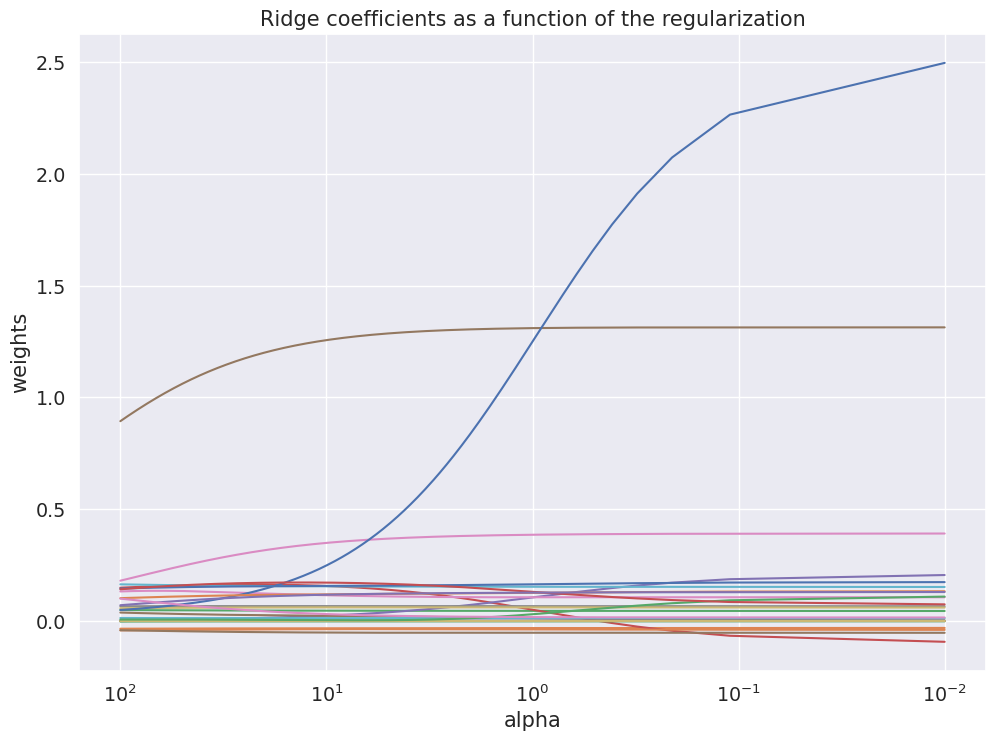

In [34]:
#Ridge Regression:
from sklearn.linear_model import RidgeCV
# clf = RidgeCV(alphas=lambgrid, cv=5)
lambgrid = np.linspace(0.01, 100, num=1000,endpoint=True)
clf = make_pipeline(RobustScaler(),RidgeCV(alphas=lambgrid, cv=5))
from sklearn.linear_model import Ridge
coefs = []
for a in lambgrid:
    ridge = Ridge(alpha=a, fit_intercept=False)
    ridge.fit(df_train, y)
    coefs.append(ridge.coef_)
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
ax.plot(lambgrid, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

In [35]:
clf.fit(df_train,y)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('ridgecv',
                 RidgeCV(alphas=array([1.00000000e-02, 1.10090090e-01, 2.10180180e-01, 3.10270270e-01,
       4.10360360e-01, 5.10450450e-01, 6.10540541e-01, 7.10630631e-01,
       8.10720721e-01, 9.10810811e-01, 1.01090090e+00, 1.11099099e+00,
       1.21108108e+00, 1.31117117e+00, 1.41126126e+00, 1.51135135e+00,
       1.61144144e+00, 1.71153153e+00...
       9.76979279e+01, 9.77980180e+01, 9.78981081e+01, 9.79981982e+01,
       9.80982883e+01, 9.81983784e+01, 9.82984685e+01, 9.83985586e+01,
       9.84986486e+01, 9.85987387e+01, 9.86988288e+01, 9.87989189e+01,
       9.88990090e+01, 9.89990991e+01, 9.90991892e+01, 9.91992793e+01,
       9.92993694e+01, 9.93994595e+01, 9.94995495e+01, 9.95996396e+01,
       9.96997297e+01, 9.97998198e+01, 9.98999099e+01, 1.00000000e+02]),
                         cv=5))])

In [36]:
preds_ridge = clf.predict(df_test)

In [37]:
from sklearn.model_selection import cross_val_score
print('Ridge Regression Cross Validation Score: %s' % (
                      cross_val_score(clf, df_train, y,scoring='neg_mean_squared_error').mean()))

Ridge Regression Cross Validation Score: -0.058950901822332036


In [38]:
#LASSO:
from sklearn.linear_model import LassoCV
# lasso_clf = LassoCV(alphas=lambgrid, cv=5)
lasso_clf = make_pipeline(RobustScaler(), LassoCV(alphas=lambgrid, cv=5))

In [39]:
lasso_clf.fit(df_train,y)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('lassocv',
                 LassoCV(alphas=array([1.00000000e-02, 1.10090090e-01, 2.10180180e-01, 3.10270270e-01,
       4.10360360e-01, 5.10450450e-01, 6.10540541e-01, 7.10630631e-01,
       8.10720721e-01, 9.10810811e-01, 1.01090090e+00, 1.11099099e+00,
       1.21108108e+00, 1.31117117e+00, 1.41126126e+00, 1.51135135e+00,
       1.61144144e+00, 1.71153153e+00...
       9.76979279e+01, 9.77980180e+01, 9.78981081e+01, 9.79981982e+01,
       9.80982883e+01, 9.81983784e+01, 9.82984685e+01, 9.83985586e+01,
       9.84986486e+01, 9.85987387e+01, 9.86988288e+01, 9.87989189e+01,
       9.88990090e+01, 9.89990991e+01, 9.90991892e+01, 9.91992793e+01,
       9.92993694e+01, 9.93994595e+01, 9.94995495e+01, 9.95996396e+01,
       9.96997297e+01, 9.97998198e+01, 9.98999099e+01, 1.00000000e+02]),
                         cv=5))])

In [40]:
preds_lasso = lasso_clf.predict(df_test)

In [41]:
# lasso_alpha = lasso_clf.alpha_
# from sklearn.linear_model import Lasso

print('Lasso Cross Validation Score: %s' % (
                      cross_val_score(lasso_clf, df_train, y,scoring='neg_mean_squared_error').mean()))

Lasso Cross Validation Score: -0.06530439089151188


In [42]:
#ElasticNet:
from sklearn.linear_model import ElasticNetCV
# elastic_clf = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1],alphas=lambgrid, cv=5)
elastic_clf = make_pipeline(RobustScaler(), ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1],alphas=lambgrid, cv=5))

In [43]:
elastic_clf.fit(df_train,y)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('elasticnetcv',
                 ElasticNetCV(alphas=array([1.00000000e-02, 1.10090090e-01, 2.10180180e-01, 3.10270270e-01,
       4.10360360e-01, 5.10450450e-01, 6.10540541e-01, 7.10630631e-01,
       8.10720721e-01, 9.10810811e-01, 1.01090090e+00, 1.11099099e+00,
       1.21108108e+00, 1.31117117e+00, 1.41126126e+00, 1.51135135e+00,
       1.61144144e+00, 1.71...
       9.76979279e+01, 9.77980180e+01, 9.78981081e+01, 9.79981982e+01,
       9.80982883e+01, 9.81983784e+01, 9.82984685e+01, 9.83985586e+01,
       9.84986486e+01, 9.85987387e+01, 9.86988288e+01, 9.87989189e+01,
       9.88990090e+01, 9.89990991e+01, 9.90991892e+01, 9.91992793e+01,
       9.92993694e+01, 9.93994595e+01, 9.94995495e+01, 9.95996396e+01,
       9.96997297e+01, 9.97998198e+01, 9.98999099e+01, 1.00000000e+02]),
                              cv=5,
                              l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]))])

In [44]:
preds_elastic = elastic_clf.predict(df_test)

In [45]:
# elastic_alpha = elastic_clf.alpha_
# from sklearn.linear_model import ElasticNet

print('ElasticNet Cross Validation Score: %s' % (
                      cross_val_score(elastic_clf, df_train, y,scoring='neg_mean_squared_error').mean()))

ElasticNet Cross Validation Score: -0.06081924618238186


In [46]:
import xgboost as xgb
xgtrain = xgb.DMatrix(df_train,label=y)
xgb_clf = xgb.XGBRegressor(n_estimators=1000, learning_rate=.03, max_depth=3,
                           subsample=1.0, random_state=0)
xgb_param = xgb_clf.get_xgb_params()

In [47]:
print('XGB Regression Cross Validation Score: %s' % (
                      cross_val_score(xgb_clf, df_train, y,scoring='neg_mean_squared_error').mean()))

XGB Regression Cross Validation Score: -0.028445810020613183


In [48]:
xgb_clf.fit(df_train,y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=0, ...)

In [49]:
preds_xgb = xgb_clf.predict(df_test)

In [50]:
# Fit Light Gradient Boosting:
lightgbm = LGBMRegressor(objective='regression', 
                         num_leaves=4,
                         learning_rate=0.01, 
                         n_estimators=5000,
                         max_bin=200, 
                         feature_fraction=0.2,
                         verbose=-1)

lightgbm.fit(df_train, y)

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2


LGBMRegressor(feature_fraction=0.2, learning_rate=0.01, max_bin=200,
              n_estimators=5000, num_leaves=4, objective='regression',
              verbose=-1)

In [51]:
preds_lgb = lightgbm.predict(df_test)

In [52]:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV

In [53]:
## Stacking
from mlxtend.regressor import StackingCVRegressor


ridge = make_pipeline(RobustScaler(),RidgeCV(alphas=lambgrid, cv=5))
lasso = make_pipeline(RobustScaler(), LassoCV(alphas=lambgrid, cv=5))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1],alphas=lambgrid, cv=5))
lightgbm = LGBMRegressor(objective='regression',
                         num_leaves=4,
                         learning_rate=0.01,
                         n_estimators=5000,
                         max_bin=200,
                         verbose=-1)
xgboost = xgb.XGBRegressor(learning_rate=0.01, n_estimators=3460,
                           max_depth=3, min_child_weight=0,
                           gamma=0, subsample=0.7,
                           colsample_bytree=0.7,
                           objective='reg:squarederror', nthread=-1,
                           scale_pos_weight=1, seed=27,
                           reg_alpha=0.00006)


stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)
stack_gen.fit(np.array(df_train), np.array(y))
stacked_preds = stack_gen.predict(np.array(df_test))

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2


In [57]:
stacked_preds = stack_gen.predict(np.array(df_test))

In [58]:
## Blending:

def blend_models_predict(preds_ridge, preds_xgb, preds_lgb):
    return (np.exp(preds_ridge) + np.exp(preds_xgb) + np.exp(preds_lgb))/3
submission = pd.DataFrame({'Id': id_test, 'SalePrice': np.exp(preds_xgb)})
# Stack Ridge Regression and XGBoost Regression Predictions
blend_preds = blend_models_predict(preds_ridge, preds_xgb, preds_lgb)
blend_submission = pd.DataFrame({'Id': id_test, 'SalePrice': blend_preds})
stacked_submission = pd.DataFrame({'Id': id_test, 'SalePrice': np.exp(stacked_preds)})

# Save Stacked and XGBoost Regression Predictions
submission.to_csv(path_or_buf = '/content/drive/MyDrive/AIFFEL/Kaggle/housing/my_submission/Submission.csv',index=False)
stacked_submission.to_csv(path_or_buf = '/content/drive/MyDrive/AIFFEL/Kaggle/housing/my_submission/Stacked_Submission.csv', index=False)
blend_submission.to_csv(path_or_buf = '/content/drive/MyDrive/AIFFEL/Kaggle/housing/my_submission/blend_submission.csv', index=False)

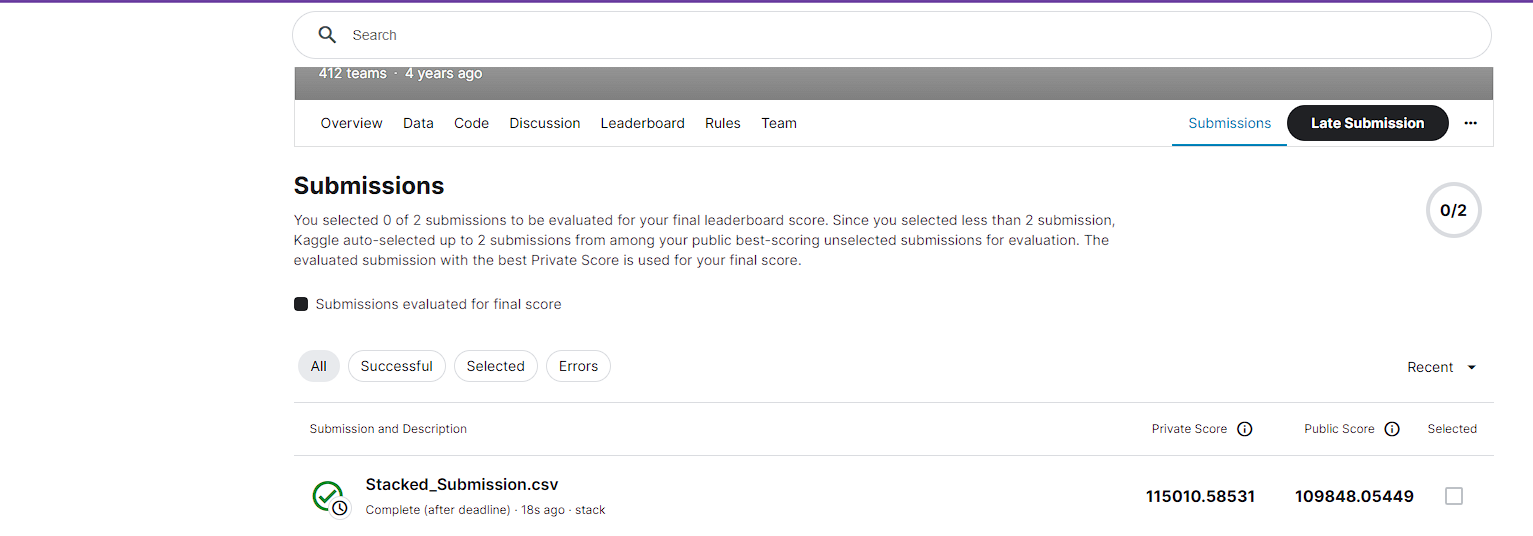